## Data Description and Importance of Microaneurysms Detection<br>
Microaneurysms Detection in Diabetic Retinopathy: Microaneurysms are the earliest visible signs of Diabetic Retinopathy (DR), a leading cause of blindness in diabetic patients. These small, round, red spots on the retina result from capillary wall outpouching and are critical indicators for the early diagnosis of DR. Detecting microaneurysms at an early stage allows for timely intervention, which can prevent the progression of DR and ultimately save a patient's vision.<br>

Dataset Overview: For this project, four well-known datasets were utilized:<br>

### DIARETDB1:<br>

Type: Retinal fundus images with corresponding annotations for diabetic retinopathy lesions.
Features: High-resolution images with annotated regions for microaneurysms, hemorrhages, and other lesions.
Target Values: Presence or absence of microaneurysms, with precise location annotations.
Challenges: The DIARETDB1 dataset provides high-quality annotations, but the variability in image contrast and brightness can pose challenges during preprocessing. This was addressed by applying techniques like contrast normalization and CLAHE (Contrast Limited Adaptive Histogram Equalization).<br>
### E-ophtha:<br>

Type: Retinal images focusing on early signs of DR, including microaneurysms.<br>
Features: Images with clear annotations for microaneurysms, suitable for training models specifically targeting early DR detection.
Target Values: Binary masks indicating microaneurysm locations.<br>
Challenges: The dataset’s images have varying resolutions and lighting conditions, which required consistent resizing and normalization to ensure uniform input to the model.<br>
### IDRid (Indian Diabetic Retinopathy Image Dataset):<br>

Type: A comprehensive dataset with multiple DR-related lesions, including microaneurysms.<br>
Features: High-resolution images with diverse patient demographics, offering a wide range of DR manifestations.<br>
Target Values: Detailed annotations for microaneurysms and other DR lesions.<br>
Challenges: The diversity in patient demographics and image quality required careful data augmentation and preprocessing to enhance the model’s robustness.<br>
### ROC (Retinopathy Online Challenge):<br>

Type: Retinal images with detailed ground truth for DR lesions, including microaneurysms.<br>
Features: Images annotated with lesion locations, providing a benchmark for model performance.<br>
Target Values: Specific coordinates and sizes for microaneurysms.<br>
Challenges: The ground truth provided in XML format required conversion to masks for model training. The difference in annotation formats between ROC and other datasets also necessitated careful alignment of training procedures.<br>  

## Data Discription <br>
##### I Used these 4 datasets and then Apply this preprocessing one by one and save it in the same Directory. The ROC have 50 Images , Diaretdb1 have 89 images and IDRid have 81 images and E_ophtha have 148 images. so the i have total 408 Images  

In [1]:
import os
import glob
import torch
import numpy as np
import cv2  # For CLAHE
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt

#### Function Crop Black Part of the image:<br>
   #### It crop the Extra Black area from the retina image and also crop the same pixels from the mask of that pic because you need the exact same pixels

In [2]:
def crop_black(image,mask):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to identify black regions
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the bounding box of the largest contour (assumed to be the black background)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Crop the image to the bounding box
        cropped_image = image[y:y+h, x:x+w]
        cropped_mask = mask[y:y+h, x:x+w]
        return cropped_image,cropped_mask

    else:
        # If no contours are found, return the original image
        return image,mask

In [3]:
def verify_shapes(dataset):
    for images, masks in dataset.take(1):  # Take one batch
        print("Image shape:", images.shape)
        print("Mask shape:", masks.shape)
        break  # Remove this if you want to check more batches

# Example usage
# verify_shapes(train_dataset)


In [4]:
import matplotlib.pyplot as plt

def show_image_and_mask(image, mask):
    """
    Display an image and its corresponding mask side by side.
    
    Parameters:
    - image: A numpy array representing the image.
    - mask: A numpy array representing the mask.
    """
    # Plot the image and mask
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display the image
    ax[0].imshow(image)  # Assumes image is in HWC format
    ax[0].set_title('Image')
    ax[0].axis('off')
    
    # Display the mask
    ax[1].imshow(mask.squeeze(), cmap='gray')  # Remove channel dimension for displaying
    ax[1].set_title('Mask')
    ax[1].axis('off')
    
    plt.show()

# Loop through the batch and display images and masks
# for images, masks in train_dataset.take(1):  # Take one batch
#     batch_size = images.shape[0]
#     for i in range(batch_size):
#         show_image_and_mask(images[i].numpy(), masks[i].numpy())


In [5]:
def min_max_normalize(image):
    # Convert the image to float32 for numerical precision
    image = image.astype(np.float32)

    # Calculate the minimum and maximum pixel values in the image
    min_val = np.min(image)
    max_val = np.max(image)

    # Perform min-max normalization
    normalized_image = (image - min_val) / (max_val - min_val)

    return normalized_image

### CLAHE Filter:
##### I simply apply the CLAHE Filter to inhance the Pixels and it convert the in to black and white because we do not have to do anything with the color the only thing that matters is the size and contract of Microanurysms that are small dots

In [6]:
def Apply_CLAHE(image):
    normalized_image = min_max_normalize(image)
    #cv2.imshow("show normalize",normalized_image)

    if len(normalized_image.shape) == 3:  # If the image has 3 channels (color)
        normalized_image = cv2.cvtColor((normalized_image * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        normalized_image = (normalized_image * 255).astype(np.uint8)
    
    # Apply CLAHE to the grayscale image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_result = clahe.apply(normalized_image)
    return clahe_result

In [11]:
dataset_path = "F:/Fyp/Preprocessing/1_Microaneurysms/Non-Aug/ROC/"
print("Dataset path:", dataset_path)
def data_load(path):
    train_x=sorted(glob.glob(os.path.join(path,"Fundus_ Images","*")))
    print(train_x)
    train_y=sorted(glob.glob(os.path.join(path,"Masks same dimensions","*")) )
                   
#     valid_x=sorted(glob(os.path.join(path,"validimages","*"))
#     valid_y=sorted(glob(os.path.join(path,"validmasks","*"))
                   
    return (train_x,train_y)

Dataset path: F:/Fyp/Preprocessing/1_Microaneurysms/Non-Aug/ROC/


['F:/Fyp/Preprocessing/1_Microaneurysms/Non-Aug/ROC/Fundus_ Images\\image0_training.jpg', 'F:/Fyp/Preprocessing/1_Microaneurysms/Non-Aug/ROC/Fundus_ Images\\image10_training.jpg', 'F:/Fyp/Preprocessing/1_Microaneurysms/Non-Aug/ROC/Fundus_ Images\\image11_training.jpg', 'F:/Fyp/Preprocessing/1_Microaneurysms/Non-Aug/ROC/Fundus_ Images\\image12_training.jpg', 'F:/Fyp/Preprocessing/1_Microaneurysms/Non-Aug/ROC/Fundus_ Images\\image13_training.jpg', 'F:/Fyp/Preprocessing/1_Microaneurysms/Non-Aug/ROC/Fundus_ Images\\image14_training.jpg', 'F:/Fyp/Preprocessing/1_Microaneurysms/Non-Aug/ROC/Fundus_ Images\\image15_training.jpg', 'F:/Fyp/Preprocessing/1_Microaneurysms/Non-Aug/ROC/Fundus_ Images\\image16_training.jpg', 'F:/Fyp/Preprocessing/1_Microaneurysms/Non-Aug/ROC/Fundus_ Images\\image17_training.jpg', 'F:/Fyp/Preprocessing/1_Microaneurysms/Non-Aug/ROC/Fundus_ Images\\image18_training.jpg', 'F:/Fyp/Preprocessing/1_Microaneurysms/Non-Aug/ROC/Fundus_ Images\\image19_training.jpg', 'F:/Fyp/Pr

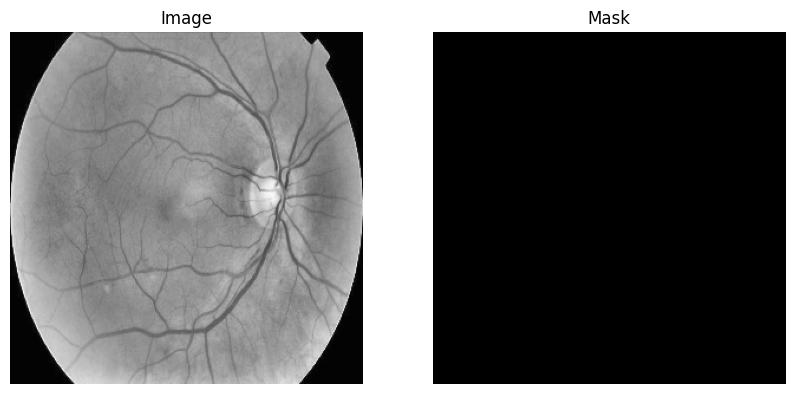

Saved processed image to F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Images\ROC_image0_training.jpg
Saved mask to F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Mask\ROC_image0_training.jpg
Image shape: (299, 299, 3)
Mask shape: (299, 299, 3)


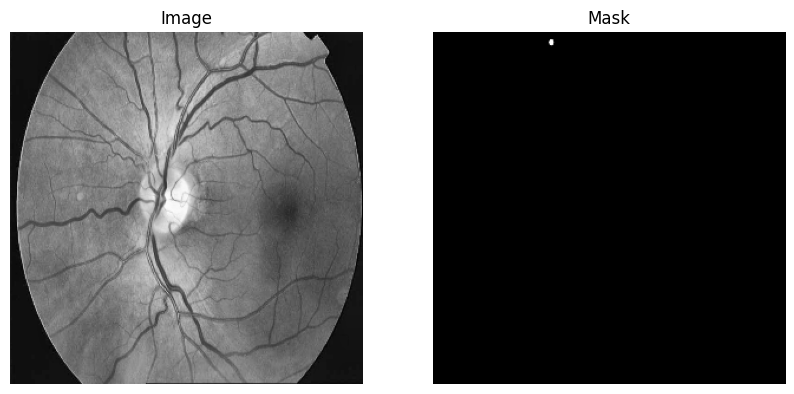

Saved processed image to F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Images\ROC_image10_training.jpg
Saved mask to F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Mask\ROC_image10_training.jpg
Image shape: (299, 299, 3)
Mask shape: (299, 299, 3)


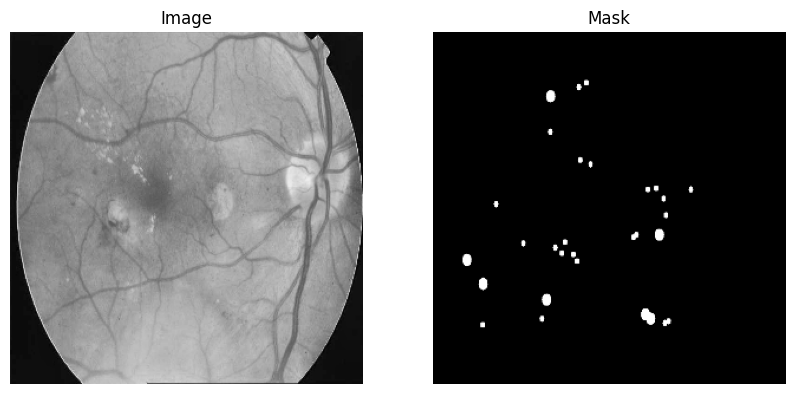

Saved processed image to F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Images\ROC_image11_training.jpg
Saved mask to F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Mask\ROC_image11_training.jpg
Image shape: (299, 299, 3)
Mask shape: (299, 299, 3)


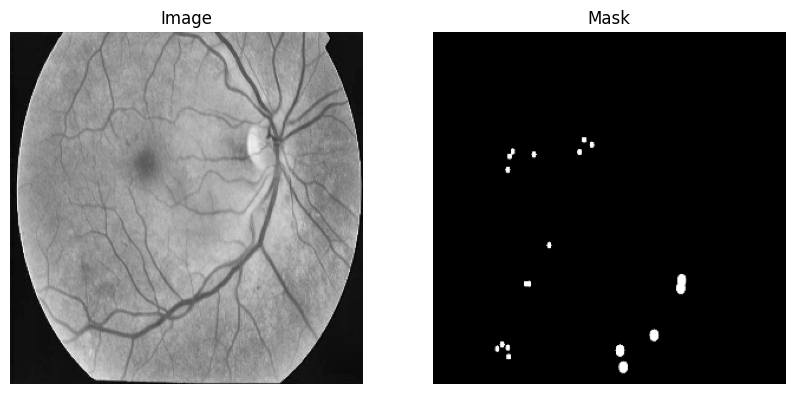

Saved processed image to F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Images\ROC_image12_training.jpg
Saved mask to F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Mask\ROC_image12_training.jpg
Image shape: (299, 299, 3)
Mask shape: (299, 299, 3)


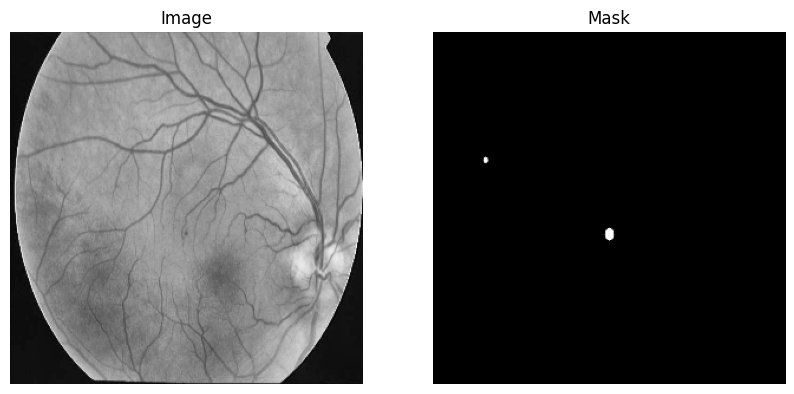

Saved processed image to F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Images\ROC_image13_training.jpg
Saved mask to F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Mask\ROC_image13_training.jpg
Image shape: (299, 299, 3)
Mask shape: (299, 299, 3)
Saved processed image to F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Images\ROC_image14_training.jpg
Saved mask to F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Mask\ROC_image14_training.jpg
Image shape: (299, 299, 3)
Mask shape: (299, 299, 3)
Saved processed image to F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Images\ROC_image15_training.jpg
Saved mask to F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Mask\ROC_image15_training.jpg
Image shape: (299, 299, 3)
Mask shape: (299, 299, 3)
Saved processed image to F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Images\ROC_image16_training.jpg
Saved mask to F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Mask\ROC_image16_training.jpg
Image shape: (299, 299, 3)
Mask shape: (299, 299, 3)


In [12]:
(train_x, train_y) = data_load(dataset_path)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Example image path: {train_x[0]}")
print(f"Example mask path: {train_y[0]}")
new_size = (299, 299)
counter=0
for i in range(len(train_x)):
    original_mask = cv2.imread(train_y[i])
    original_image = cv2.imread(train_x[i])
    if original_image is None or original_mask is None:
        print(f"Error: Could not load image or mask for index {i}")
        continue  # Skip to the next iteration if loading fails

    cropped_retina_image,cropped_mask = crop_black(original_image,original_mask)
    
    cropped_retina_image = cv2.resize(cropped_retina_image, new_size)

    cropped_mask = cv2.resize(cropped_mask, new_size)
    cropped_mask = cv2.cvtColor(cropped_mask, cv2.COLOR_BGR2RGB)
    

    
    clahe_image=Apply_CLAHE(cropped_retina_image)
    clahe_image = cv2.cvtColor(clahe_image, cv2.COLOR_BGR2RGB)
    print("Image shape:", clahe_image.shape)
    print("Mask shape:", cropped_mask.shape)
    if counter < 5:
        show_image_and_mask(clahe_image, cropped_mask)
        counter += 1
    base_filename = os.path.basename(train_x[i])
    file_name, file_extension = os.path.splitext(base_filename)
    
    # Construct new filenames for the processed images
    retina_save_path = os.path.join("F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Images", f"ROC_{file_name}{file_extension}")
    mask_save_path = os.path.join("F:/Fyp/Preprocessing/1_Microaneurysms/Processed/Mask", f"ROC_{file_name}{file_extension}")
    if cv2.imwrite(retina_save_path, clahe_image):
        print(f"Saved processed image to {retina_save_path}")
    else:
        print(f"Failed to save processed image to {retina_save_path}")
    
    if cv2.imwrite(mask_save_path, cropped_mask):
        print(f"Saved mask to {mask_save_path}")
    else:
        print(f"Failed to save mask to {mask_save_path}")

In [ ]:
for i in range(len(train_x)):
    print("Image shape:", cropped_retina_image.shape)
    print("Mask shape:", cropped_mask.shape)
    show_image_and_mask(cropped_retina_image, cropped_mask)
    